In [1]:
import pandas as pd
import geopandas as gpd
import shapely 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Description / summary

## Shape of crimes data (quickly)

In [2]:
# Raw data ingest
raw_crimes = pd.read_csv('./data/chicago_crime_data.csv')
# for filling in missing crime locations
beat_shapes = gpd.read_file('./data/chicago_beat_geo_data.json')

In [3]:
raw_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,7685111,HS484316,08/27/2010 10:00:00 AM,058XX W DIVERSEY AVE,031A,ROBBERY,ARMED: HANDGUN,GROCERY FOOD STORE,False,False,...,30.0,19.0,03,1136766.0,1918012.0,2010,02/04/2016 06:33:39 AM,41.931184,-87.772831,"(41.931184467, -87.772830927)"
1,7685114,HS457262,08/11/2010 03:10:00 PM,063XX S CAMPBELL AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,15.0,66.0,19,1160796.0,1862497.0,2010,02/04/2016 06:33:39 AM,41.778381,-87.686063,"(41.778380602, -87.686062637)"
2,7685119,HS490207,08/30/2010 03:50:00 PM,018XX N RICHMOND ST,1350,CRIMINAL TRESPASS,TO STATE SUP LAND,"SCHOOL, PUBLIC, GROUNDS",True,False,...,35.0,22.0,26,1156527.0,1912063.0,2010,02/04/2016 06:33:39 AM,41.914482,-87.700374,"(41.914482493, -87.700373861)"
3,7685120,HS491229,08/31/2010 08:00:00 AM,041XX W MELROSE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,True,True,...,31.0,16.0,08B,1148306.0,1921289.0,2010,02/04/2016 06:33:39 AM,41.939962,-87.730338,"(41.939961992, -87.730338452)"
4,7685121,HS423475,07/22/2010 06:00:00 AM,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,GOVERNMENT BUILDING/PROPERTY,True,False,...,41.0,76.0,18,1100088.0,1926079.0,2010,02/04/2016 06:33:39 AM,41.953900,-87.907473,"(41.953900467, -87.907472601)"


In [4]:
df_MB = raw_crimes.memory_usage()/1e6

In [5]:
print('Memory usage:')
print('Total = ' + str(df_MB.sum()))
print()
print('Breakdown:')
print(df_MB)

Memory usage:
Total = 1040.119298

Breakdown:
Index                    0.000080
ID                      51.363912
Case Number             51.363912
Date                    51.363912
Block                   51.363912
IUCR                    51.363912
Primary Type            51.363912
Description             51.363912
Location Description    51.363912
Arrest                   6.420489
Domestic                 6.420489
Beat                    51.363912
District                51.363912
Ward                    51.363912
Community Area          51.363912
FBI Code                51.363912
X Coordinate            51.363912
Y Coordinate            51.363912
Year                    51.363912
Updated On              51.363912
Latitude                51.363912
Longitude               51.363912
Location                51.363912
dtype: float64


An important column is not entirely populated... the coordinates. In these cases, we use the most granular thing we know (the beat) and randomly sample within it. This is an approximation to correctly attribute crimes without precise lat/lng tagging to neighborhoods. In general, this affects roughly 1 - 5% of total records, depending on the year.

In [6]:
yr_check = raw_crimes.groupby('Year').count()
print('Fraction of incidents without location by year:')
1 - yr_check['Location']/yr_check['ID']

Fraction of incidents without location by year:


Year
2001    0.005869
2002    0.031259
2003    0.008148
2004    0.004598
2005    0.008290
2006    0.005609
2007    0.002909
2008    0.016300
2009    0.016720
2010    0.004300
2011    0.002124
2012    0.003059
2013    0.008223
2014    0.019372
2015    0.013849
2016    0.063109
2017    0.036373
dtype: float64

In [7]:
yr_check

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Updated On,Latitude,Longitude,Location
Year,,,,,,,,,,,,,,,,,,,,,
2001,485732,485732,485732,485732,485732,485732,485732,485730,485732,485732,...,485732,4106,4095,485732,482881,482881,485732,482881,482881,482881
2002,486741,486741,486741,486741,486741,486741,486741,486737,486741,486741,...,486741,353616,353581,486741,471526,471526,486741,471526,471526,471526
2003,475917,475917,475917,475917,475917,475917,475917,475915,475917,475917,...,475917,475898,475869,475917,472039,472039,475917,472039,472039,472039
2004,469358,469358,469358,469358,469358,469358,469358,469349,469358,469358,...,469356,469336,469292,469358,467200,467200,469358,467200,467200,467200
2005,453683,453683,453683,453683,453683,453683,453683,453676,453683,453683,...,453682,453682,453629,453683,449922,449922,453683,449922,449922,449922
2006,448059,448059,448059,448059,448059,448059,448059,448048,448059,448059,...,448058,448056,448010,448059,445546,445546,448059,445546,445546,445546
2007,436959,436959,436959,436959,436959,436959,436959,436952,436959,436959,...,436957,436954,436801,436959,435688,435688,436959,435688,435688,435688
2008,426990,426990,426990,426990,426990,426990,426990,426980,426990,426990,...,426950,426986,426747,426990,420030,420030,426990,420030,420030,420030
2009,392594,392592,392594,392594,392594,392594,392594,392582,392594,392594,...,392594,392591,392375,392594,386030,386030,392594,386030,386030,386030


## Cleaning and formatting the crime data

### Only keeping points where we can associate neighborhoods

The crimes are not tagged by neighborhood. We can associate to neighborhood in cases where we have lat/lng data -- but not all incidents contain this information (though about 98% do). For those that don't, we can approximate the crime location by randomly sampling from within the police beat, the lowest level of granularity geo-tagging available behind the lat/lng.

In cases where we don't have an existing beat associated with the incident AND we don't have lat/lng data, drop the rows. We could iteratively apply the same logic and approximate from the ward level, but this has it's own caveats (i.e. the wards were restruck, effective in 2015) and would only give us clarity on 5 in 10000 crimes. Not worth the effort.

In [8]:
beats_geo_dict_arb_keys = beat_shapes.set_index('beat_num')['geometry'].to_dict()
beats_geo_dict = { int(key) : beats_geo_dict_arb_keys[key] for key in beats_geo_dict_arb_keys}

In [9]:
entries_without_loc_or_beat =\
    raw_crimes['Location'].isnull() & raw_crimes['Beat'].map(lambda beat: beat not in beats_geo_dict)

In [10]:
print('beats no longer in map:')
print(sorted([ beat for beat in raw_crimes['Beat'].unique() if beat not in beats_geo_dict]))
print()
print('percent of crimes w/o location in a beat not on map:', entries_without_loc_or_beat.sum()/len(raw_crimes))

beats no longer in map:
[134, 310, 430, 1311, 1312, 1313, 1322, 1323, 1324, 1331, 1332, 1333, 2111, 2112, 2113, 2122, 2123, 2124, 2131, 2132, 2133, 2311, 2312, 2313, 2322, 2323, 2324, 2331, 2332, 2333]

percent of crimes w/o location in a beat not on map: 0.000532669707868


In [11]:
crimes_with_loc_tags = raw_crimes[entries_without_loc_or_beat == False].copy().reset_index()

### Fill in missing locations from beat

As mentioned above, when we don't have precise location data we don't know which neighborhood the crime occurred in -- and neighborhoods are the target crime representation since they're easy references for a narrative. Police beats are small compared to other available tags (like ward or district), and hence sampling from within one of these should give us a reasonable approximation for neighborhood.

Note, we do have block data for all incidents. However, to use this data to identify neighborhood we would need a street map, which due to the fact that this effect is now far on the margin, is not worth the complexity.

In [12]:
import random
random.seed(1337)

def sample_within_beat(beat_poly):
    x_min, y_min, x_max, y_max = beat_poly.bounds
    while True:
        candidate = shapely.geometry.Point([random.uniform(x_min, x_max), random.uniform(y_min, y_max)])
        if beat_poly.contains(candidate):
            return candidate   
        
def points_filled_by_beat(latitude, longitude, beat_num, beat_dict):
    if np.isnan(latitude) or np.isnan(longitude):
        return sample_within_beat(beat_dict[beat_num])
    else:
        return shapely.geometry.Point([longitude, latitude])

In [13]:
crime_points = [\
   points_filled_by_beat(crimes_with_loc_tags['Latitude'][i], 
                         crimes_with_loc_tags['Longitude'][i], 
                         crimes_with_loc_tags['Beat'][i], 
                         beats_geo_dict)\
   for i in range(len(crimes_with_loc_tags))\
]

In [14]:
temp_latlng = pd.DataFrame({ 'lng' : [ pt.x for pt in crime_points ], 'lat' : [ pt.y for pt in crime_points ] })

In [15]:
# save intermediate step ... the analysis is heavy and long in it's batch form
temp_latlng.to_csv('./cache/temp_latlng.csv')

In [3]:
#temp_latlng = pd.read_csv('./cache/temp_latlng.csv')

### Tag crimes by neighborhood

Grab the series of points from Lat / Lng crime data, then produce series of neighborhoods

Some help from (here and the section after)...
* http://geopandas.org/mergingdata.html
* https://gis.stackexchange.com/questions/190903/assign-a-point-to-polygon-using-pandas-and-shapely
* http://blog.yhat.com/posts/interactive-geospatial-analysis.html

#### Shape of neighborhood data (quickly)



In [15]:
# Use "community areas" as neighborhoods 
# note there is a neighborhoods file that's slightly different, but community areas are more meaningful
#   and other sources, such as some census aggregations, use these lines
neighborhoods = gpd.read_file('./data/chicago_commarea_geo_data.json')

In [16]:
neighborhoods.describe()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
count,77,77,77,77,77,77,77,77,77,77
unique,77,1,77,1,77,77,1,1,77,77
top,PORTAGE PARK,0,103595001.175,0,60,60,0,0,28175.3160866,(POLYGON ((-87.60157012805959 41.6862093549865...
freq,1,77,1,77,1,1,77,77,1,1


Hyde park stomping grounds


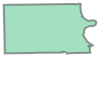

In [17]:
hp_loc = neighborhoods.index[neighborhoods['community'] == 'HYDE PARK'][0]
print('Hyde park stomping grounds')
neighborhoods['geometry'][hp_loc]

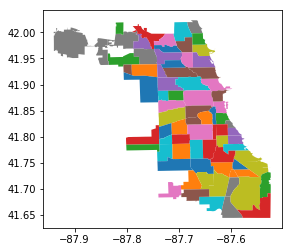

In [18]:
neighborhoods.plot(column = 'community')
plt.show()

#### Back to tagging neighborhoods

In [19]:
crime_points_gdf = gpd.GeoDataFrame({'geometry' : crime_points})
# Declare the coordinate system for the places GeoDataFrame
# GeoPandas doesn't do any transformations automatically when performing
# the spatial join. The layers are already in the same CRS (WGS84) so no
# transformation is needed.
crime_points_gdf.crs = {'init': 'epsg:4326'}

In [20]:
crimes_by_neighb = gpd.sjoin(crime_points_gdf, neighborhoods, how='left')

In [21]:
# save intermediate step ... the analysis is heavy and long in it's batch form
crimes_by_neighb[['community']].to_csv('./cache/temp_neighb_assoc.csv')

In [4]:
#crimes_by_neighb = pd.read_csv('./cache/temp_neighb_assoc.csv')

#### Take a quick look at counts

In [22]:
neighb_with_count =\
    crimes_by_neighb.groupby('community')[['index_right']].count().join(neighborhoods.set_index('community'))

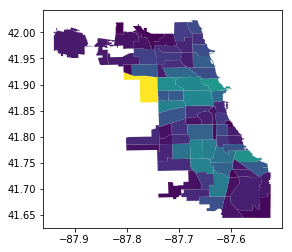

In [23]:
gpd.GeoDataFrame(neighb_with_count).plot(column = 'index_right')
plt.show()

## Use FBI crime classification

The FBI NIBRS crime classification is the one of preference in the current context because it is an aggregate / summary-level crime tagging.

Descriptions obtained from http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html

In [24]:
nibrs_map = pd.read_csv('./data/nibrs_map.csv')

In [25]:
crime_nibrs_descr = pd.merge(crimes_with_loc_tags[['FBI Code']], 
                             nibrs_map, 
                             left_on='FBI Code', 
                             right_on = 'code', 
                             how = 'left')

In [26]:
print('integrity check that number of rows stayed constant:', len(crime_nibrs_descr) == len(crimes_with_loc_tags))

integrity check that number of rows stayed constant: True


In [27]:
crime_nibrs_descr.head()

,FBI Code,code,description,is_index,crime_type
0,03,03,Robbery,True,Property
1,19,19,Gambling,False,Other
2,26,26,Misc Non-Index Offense,False,Other
3,08B,08B,Simple Battery,False,Violent
4,18,18,Drug Abuse,False,Other


In [28]:
crimes_with_loc_tags.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,7685111,HS484316,08/27/2010 10:00:00 AM,058XX W DIVERSEY AVE,031A,ROBBERY,ARMED: HANDGUN,GROCERY FOOD STORE,False,...,30.0,19.0,03,1136766.0,1918012.0,2010,02/04/2016 06:33:39 AM,41.931184,-87.772831,"(41.931184467, -87.772830927)"
1,1,7685114,HS457262,08/11/2010 03:10:00 PM,063XX S CAMPBELL AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,...,15.0,66.0,19,1160796.0,1862497.0,2010,02/04/2016 06:33:39 AM,41.778381,-87.686063,"(41.778380602, -87.686062637)"
2,2,7685119,HS490207,08/30/2010 03:50:00 PM,018XX N RICHMOND ST,1350,CRIMINAL TRESPASS,TO STATE SUP LAND,"SCHOOL, PUBLIC, GROUNDS",True,...,35.0,22.0,26,1156527.0,1912063.0,2010,02/04/2016 06:33:39 AM,41.914482,-87.700374,"(41.914482493, -87.700373861)"
3,3,7685120,HS491229,08/31/2010 08:00:00 AM,041XX W MELROSE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,True,...,31.0,16.0,08B,1148306.0,1921289.0,2010,02/04/2016 06:33:39 AM,41.939962,-87.730338,"(41.939961992, -87.730338452)"
4,4,7685121,HS423475,07/22/2010 06:00:00 AM,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,GOVERNMENT BUILDING/PROPERTY,True,...,41.0,76.0,18,1100088.0,1926079.0,2010,02/04/2016 06:33:39 AM,41.953900,-87.907473,"(41.953900467, -87.907472601)"


### Casting and output

Some of the data at this point is either redundant or not useful for downstream analysis. Here we will select and cast data in the appropriate way given downstream use cases.



In [29]:
crimes_with_loc_tags.dtypes

index                     int64
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [30]:
cleaned_crimes = pd.DataFrame({
    'date'              : crimes_with_loc_tags['Date'],
    'year'              : crimes_with_loc_tags['Year'].map(int),
    'crime_description' : crime_nibrs_descr['description'].map(str),
    'crime_is_index'    : crime_nibrs_descr['is_index'].map(bool),
    'crime_type'        : crime_nibrs_descr['crime_type'].map(str),
    'location_type'     : crimes_with_loc_tags['Location Description'].map(str),
    'arrest'            : crimes_with_loc_tags['Arrest'],
    'domestic'          : crimes_with_loc_tags['Domestic'],
    'fbi_code'          : crimes_with_loc_tags['FBI Code'].map(str),
    'lat'               : temp_latlng['lat'].map(float),
    'lng'               : temp_latlng['lng'].map(float),
    'neighborhood'      : crimes_by_neighb['community']
})

In [31]:
cleaned_crimes.head()

,arrest,crime_description,crime_is_index,crime_type,date,domestic,fbi_code,lat,lng,location_type,neighborhood,year
0,False,Robbery,True,Property,08/27/2010 10:00:00 AM,False,03,41.931184,-87.772831,GROCERY FOOD STORE,BELMONT CRAGIN,2010
1,True,Gambling,False,Other,08/11/2010 03:10:00 PM,False,19,41.778381,-87.686063,SIDEWALK,CHICAGO LAWN,2010
2,True,Misc Non-Index Offense,False,Other,08/30/2010 03:50:00 PM,False,26,41.914482,-87.700374,"SCHOOL, PUBLIC, GROUNDS",LOGAN SQUARE,2010
3,True,Simple Battery,False,Violent,08/31/2010 08:00:00 AM,True,08B,41.939962,-87.730338,RESIDENCE,IRVING PARK,2010
4,True,Drug Abuse,False,Other,07/22/2010 06:00:00 AM,False,18,41.953900,-87.907473,GOVERNMENT BUILDING/PROPERTY,OHARE,2010


In [32]:
cleaned_crimes.to_csv('./data/cleaned_crimes.csv')